In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import itertools
from collections import defaultdict, OrderedDict
from random import shuffle
from tqdm import tqdm_notebook as tqdm, tnrange as trange
from sklearn.metrics import confusion_matrix

from evalResult import get_predicted, get_observed
plt.style.use('seaborn')

In [2]:
dataset = 'EN'

## Hyperparameters
Here for easy tuning.

In [3]:
# optimal 1e-4
lr = 1e-4
n_epochs = 20

## Data

### Cleaning
Prepare words for cleaning. Specifically, find
1. ~~stopwords~~
1. punctuation
1. hashtags
1. @ mentions
1. numbers
1. URLs

In [4]:
re_punc = r'^[^a-zA-Z0-9]+$'
re_hash = r'^#'
re_at = r'^@'
re_num = r'\d'  # just remove all words with numbers
re_url = r'(^http:|\.com$)'

In [5]:
def clean_word(w):
    w = w.strip()
    if re.match(re_punc, w):
        return '#PUNC#'
    if re.match(re_hash, w):
        return '#HASH#'
    if re.match(re_at, w):
        return '#AT#'
    if re.match(re_num, w):
        return '#NUM#'
    if re.match(re_url, w):
        return '#URL#'
    return w.lower()

### I/O

In [6]:
def parse(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()

    observations, states = defaultdict(int), defaultdict(int)
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            obs, state = data_split
            observations[clean_word(obs)] += 1
            states[state] += 1
    return observations, states

In [7]:
def read_file(filename, clean=True):
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    sentence, label = [], []
    sentences, labels = [], []
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            word, state = data_split
            if clean:
                word = clean_word(word)
            sentence.append(word)
            label.append(state)
        else:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []
    return sentences, labels

### Train data

In [8]:
train_filename = f'data/{dataset}/train'

observations, states = parse(train_filename)

In [9]:
train_sentences, train_labels = read_file(train_filename)
train_sentences[0][:5], train_labels[0][:5]

(['rt', '#AT#', '#PUNC#', 'encore', '#PUNC#'], ['O', 'O', 'O', 'B-INTJ', 'O'])

### Validation data

In [10]:
val_filename = f'data/{dataset}/dev.out'
val_sentences, val_labels = read_file(val_filename)
val_sentences[0][:5], val_labels[0][:5]

(['no', 'saints', 'r', '#PUNC#', 'buch'],
 ['B-NP', 'I-NP', 'I-NP', 'O', 'B-NP'])

In [11]:
out_filename = f'data/{dataset}/dev.p5.out'

## Encoding

In [12]:
def one_hot_encode(n, depth):
    a = np.zeros([depth, 1])
    a[n, 0] = 1
    return a

### Encode words
Create a vocabulary out of words that appear more than `1` time(s) in training. Each word now maps to an _integer_. Other words will be treated as `#UNK#`.

In [13]:
def tokenize(token_mapping, sentence):
    """
    Function to convert each word into its corresponding integer
    If word is not found, return the value for '#UNK'
    """
    return [token_mapping.get(w, token_mapping['#UNK#']) for w in sentence]

def prepare_inputs(token_mapping, sentences):
    """
    Converts a 2-D list of sentences (list of list of words)
    to one-hot encoded tokens of shape [n_sentences, n_words, len(token_mapping), 1].
    """
    tokens = [tokenize(token_mapping, sentence) for sentence in sentences] 
    
    depth = len(token_mapping)
    one_hot_tokens = []
    for sentence in tokens:
        one_hot_sentence = []
        for i, token in enumerate(sentence):
            if token != token_mapping['#UNK#']:
                one_hot_sentence.append(one_hot_encode(token, depth))
            else:
                if i == 0:
                    one_hot_sentence.append((one_hot_encode(sentence[i+1], depth) + one_hot_encode(sentence[i+2], depth))/2)
                elif i == 1:
                    one_hot_sentence.append((one_hot_encode(sentence[i-1], depth) + one_hot_encode(sentence[i+1], depth) + one_hot_encode(sentence[i+2], depth))/3)
                elif i == (len(sentence)-1):
                    one_hot_sentence.append((one_hot_encode(sentence[i-2], depth) + one_hot_encode(sentence[i-1], depth))/2)
                elif i == (len(sentence)-2):
                    one_hot_sentence.append((one_hot_encode(sentence[i-2], depth) + one_hot_encode(sentence[i-1], depth) + one_hot_encode(sentence[i+1], depth))/3)
                else:
                    one_hot_sentence.append((one_hot_encode(sentence[i-2], depth) + one_hot_encode(sentence[i-1], depth) + one_hot_encode(sentence[i+1], depth) + one_hot_encode(sentence[i+2], depth))/4)
        one_hot_tokens.append(one_hot_sentence)
    # one_hot_tokens = [[one_hot_encode(token, depth) for token in sentence] for sentence in tokens]
    one_hot_tokens = [np.asarray(ls) for ls in one_hot_tokens]  # list of [n_words, len(token_mapping), 1]
    return one_hot_tokens

In [14]:
min_freq = 0

token_mapping = {}
for word in observations:
    if observations[word] > min_freq:  # appears more than once in training
        token_mapping[word] = len(token_mapping)
token_mapping['#UNK#'] = len(token_mapping)
len(token_mapping)

2504

In [15]:
X_train = prepare_inputs(token_mapping, train_sentences)
len(X_train), X_train[0].shape

(551, (25, 2504, 1))

### Encode labels
Perform a similar encoding for the states:
1. Map to integer
1. Convert from integer to one-hot-encoding

In [16]:
def prepare_labels(state_mapping, sequences):
    """
    Convert each state from str to its corresponding int value.
    Convert the int to a one-hot vector.
    """
    encoded_labels = [[state_mapping[state] for state in label] for label in sequences]
    
    depth = len(state_mapping)
    one_hot_labels = [[one_hot_encode(label, depth) for label in sequence] for sequence in encoded_labels]
    one_hot_labels = [np.asarray(ls) for ls in one_hot_labels]
    return one_hot_labels

In [17]:
state_mapping = {state: i for i, state in enumerate(states)}
state_mapping

{'O': 0,
 'B-INTJ': 1,
 'B-PP': 2,
 'B-NP': 3,
 'I-NP': 4,
 'B-VP': 5,
 'B-PRT': 6,
 'I-VP': 7,
 'B-ADJP': 8,
 'B-SBAR': 9,
 'B-ADVP': 10,
 'I-INTJ': 11,
 'B-CONJP': 12,
 'I-CONJP': 13,
 'I-ADVP': 14,
 'I-ADJP': 15,
 'I-SBAR': 16,
 'I-PP': 17}

In [18]:
y_train = prepare_labels(state_mapping, train_labels)
len(y_train), y_train[0].shape

(551, (25, 18, 1))

### Validation
Perform a similar encoding for validation data, based on the states and tokens of the training data.

In [19]:
X_val = prepare_inputs(token_mapping, val_sentences)
y_val = prepare_labels(state_mapping, val_labels)

## RNN
$$
    a^{(t)} = b + Wh^{(t-1)} + Ux^{(t)} \\
    h^{(t)} = \text{tanh}(a^{(t)}) \\
    \\
    o^{(t)} = c + Vh^{(t)} \\
    \hat{y}^{(t)} = \text{softmax}(o^{(t)})
$$

In [20]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

### Initialization

In [21]:
np.random.seed(0)

rnn_size = 128
# input
U = np.random.normal(0, 0.1, size=[rnn_size, len(token_mapping)])
# hidden layer
W = np.random.normal(0, 0.1, size=[rnn_size, rnn_size])
b = np.ones(shape=[rnn_size, 1]) * 0.1
# output
V = np.random.normal(0, 0.1, size=[len(state_mapping), rnn_size])
c = np.ones(shape=[len(state_mapping), 1]) * 0.1

In [22]:
model = (U, W, b, V, c)  # time for some unpacking magic

### Forward

In [23]:
def forward(U, W, b, V, c, x):
    """
    Compute the outputs at each time step.
    Note that in the forward function, we only store y_ at each time step.
    """
    y_ = []
    # initialize h_1
    h = np.tanh(b + U.dot(x[0]))
    o = c + V.dot(h)
    y_.append(softmax(o))
    # iterate for [h_t, .., h_n]
    for i in range(1, len(x)):
        h = np.tanh(b + W.dot(h) + U.dot(x[i]))
        o = c + V.dot(h)
        y_.append(softmax(o))
    return np.array(y_)

y_ = forward(*model, x=X_train[0])
y_.shape

(25, 18, 1)

In [24]:
np.argmax(y_, axis=1).flatten()

array([17,  6,  6,  9, 11,  8,  7,  5, 14, 15,  6, 11, 17,  1,  6, 11,  8,
        6,  8, 11, 11,  9, 15, 11, 14])

### Evaluation

In [25]:
def predict(logits):
    states = list(state_mapping)
    probs = softmax(logits)
    indices = np.argmax(probs, axis=1)  # take argmax of the probs
    return [states[int(i)] for i in indices]  # map indices back to states

In [26]:
def write_predictions(*args, X):
    # get and store predictions
    result = []
    for i in trange(len(X_val), leave=False):
        y_pred = predict(forward(*args, x=X_val[i]))
        result.append(y_pred)
    # write predictions to file
    with open(out_filename, 'w') as f:
        for i in range(len(val_sentences)):
            for j in range(len(val_sentences[i])):
                word = val_sentences[i][j]
                pred = result[i][j]
                f.write(word + ' ' + pred + '\n')
            f.write('\n')

In [27]:
def compare(observed, predicted):
    correct_sentiment = 0
    correct_entity = 0

    total_observed = 0.0
    total_predicted = 0.0

    #For each Instance Index example (example = 0,1,2,3.....)
    for example in observed:
        observed_instance = observed[example]
        predicted_instance = predicted[example]

        #Count number of entities in gold data
        total_observed += len(observed_instance)
        #Count number of entities in prediction data
        total_predicted += len(predicted_instance)

        #For each entity in prediction
        for span in predicted_instance:
            span_begin = span[1]
            span_length = len(span) - 1
            span_ne = (span_begin, span_length)
            span_sent = span[0]

            #For each entity in gold data
            for observed_span in observed_instance:
                begin = observed_span[1]
                length = len(observed_span) - 1
                ne = (begin, length)
                sent = observed_span[0]

                #Entity matched
                if span_ne == ne:
                    correct_entity += 1
                    #Entity & Sentiment both are matched
                    if span_sent == sent:
                        correct_sentiment += 1

    prec = correct_entity/total_predicted
    rec = correct_entity/total_observed
    if abs(prec + rec) < 1e-6:
        f = 0
    else:
        f = 2 * prec * rec / (prec + rec)
    entity_scores = (prec, rec, f)

    prec = correct_sentiment/total_predicted
    rec = correct_sentiment/total_observed
    if abs(prec + rec) < 1e-6:
        f = 0
    else:
        f = 2 * prec * rec / (prec + rec)
    type_scores = (prec, rec, f)
    return entity_scores, type_scores

def get_scores(*args, X):
    write_predictions(*args, X=X_val)
    observed = get_observed(open(val_filename, 'r'))
    predicted = get_predicted(open(out_filename, 'r'))
    return compare(observed, predicted)

get_scores(*model, X=X_val)

((0.37949101796407186, 0.6321695760598504, 0.47427502338634236),
 (0.04640718562874251, 0.0773067331670823, 0.05799812909260992))

### Backward
`<insert derived backpropagation equations here>`

#### Weighting
We create two sets of weights for mis-classifying each class:
* `count_weights`: based on frequency of occurrences of each class
* `label_weights`: based on importance of correctly predicting certain classes

In [28]:
count_weights = np.asarray(list(states.values()))
count_weights = 1 / count_weights
count_weights /= np.max(count_weights)
count_weights = np.maximum(0.2, count_weights)
count_weights = count_weights.reshape(-1, 1)
count_weights

array([[0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [1.        ],
       [1.        ],
       [0.2       ],
       [0.2       ],
       [0.5       ],
       [0.33333333]])

In [29]:
label_weights = OrderedDict()
for k in states:
    if k == 'O':
        label_weights[k] = 1
    elif k.startswith('B'):
        label_weights[k] = 1
    elif k.startswith('I'):
        label_weights[k] = 1
    else:
        label_weights[k] = 1
label_weights = np.asarray(list(label_weights.values())).reshape(-1, 1)

In [30]:
weights = label_weights * count_weights
assert weights.shape == (len(states), 1)

#### Gradients

In [31]:
def jacobian(h):
    """
    Returns the Jacobian of tanh(h).
    """
    diag_elems = (1 - h**2).flatten()
    return np.diag(diag_elems)
    

def backward(U, W, b, V, c, x, y):
    assert len(x) == len(y)
    n = len(x)
    if n <= 1:
        return np.nan, (0, 0, 0, 0, 0)
    
    # feedforward
    h_1 = np.tanh(b + U.dot(x[0]))
    h = [h_1]
    for i in range(1, n):
        h_t = np.tanh(b + W.dot(h[-1]) + U.dot(x[i]))
        h.append(h_t)

    o = [c + V.dot(h_t) for h_t in h]
    
    # backprop
    do = [softmax(o[i]) - y[i] for i in range(n)]
    
    dh_n = V.T.dot(do[-1])  # h_n has no (t+1) gradient
    dh = [dh_n]
    for i in range(n-2, -1, -1):
        dh_t = W.T.dot(jacobian(h[i+1])).dot(dh[0]) + V.T.dot(do[i])
        dh.insert(0, dh_t)
        
    dc = np.sum(do, axis=0)
    dV = np.sum([do[i].dot(dh[i].T) for i in range(n)], axis=0)
    
    delta_h = [jacobian(h[i]).dot(dh[i]) for i in range(n)]  # propagated error term of h
    db = np.sum(delta_h, axis=0)
    dW = np.sum([delta_h[i].dot(h[i-1].T) for i in range(1, n)], axis=0)  # t=1 has no prev
    dU = np.sum([delta_h[i].dot(x[i].T) for i in range(n)], axis=0)
    
    assert dc.shape == c.shape
    assert dV.shape == V.shape
    assert db.shape == b.shape
    assert dW.shape == W.shape
    assert dU.shape == U.shape

    grad = (dU, dW, db, dV, dc)
    
    # compute loss
    y_ = [softmax(o_t) for o_t in o]
    xent = [-np.log(y_[i] + 1e-8) * y[i] for i in range(n)]
    loss = np.mean(np.sum(xent, axis=1))  # sum softmax CE for each word, then take mean across all words
    return loss, grad
        
# for i in trange(len(X_train)):
#     backward(*model, x=X_train[i], y=y_train[i])

## Training

In [32]:
checkpoints = []  # save model weights after every epoch
training_indices = []  # track each sentence for loss checking
losses  = []
scores = []
for i in trange(n_epochs):
    indices = list(range(len(X_train)))
    shuffle(indices)
    training_indices.extend(indices)  # since they are shuffled, remember them
    for j in tqdm(indices, leave=False):
        x, y = X_train[j], y_train[j]
        loss, grad = backward(*model, x=x, y=y)
        
        losses.append(loss)
        for error, weight in zip(grad, model):
            weight -= lr * error
    
    scores.append(get_scores(*model, X=X_val))
    checkpoints.append(tuple(weights.copy() for weights in model))

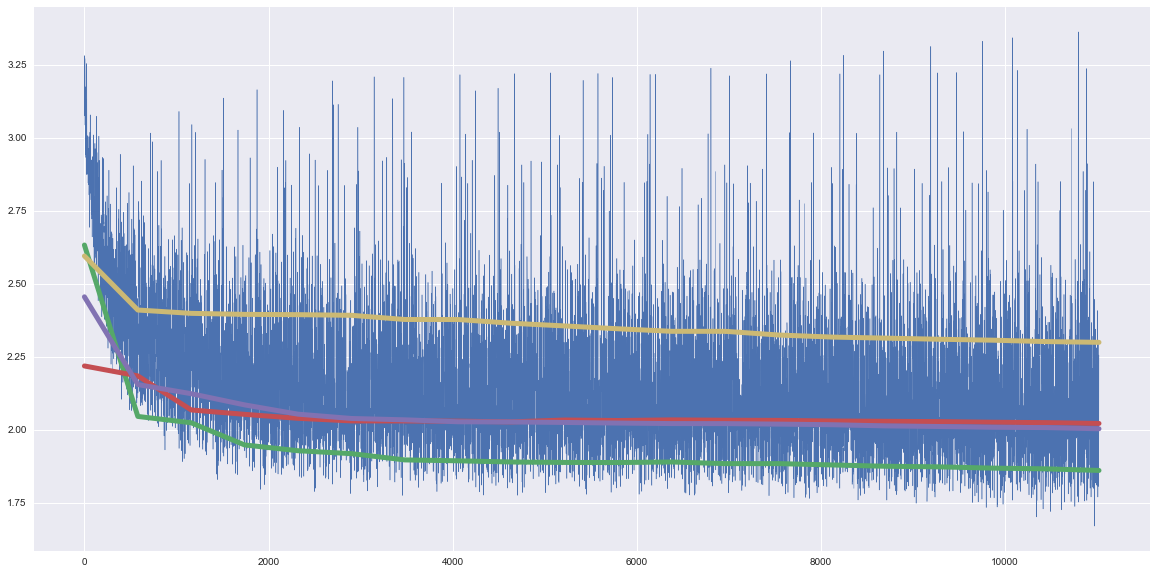

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(losses)), losses, linewidth=0.5)  # overall training loss

training_indices = np.asarray(training_indices)
losses = np.asarray(losses)
for i in range(4):
    x = np.linspace(0, len(losses), n_epochs)
    y = losses[np.where(training_indices == i)]
    plt.plot(x, y, linewidth=5.0)

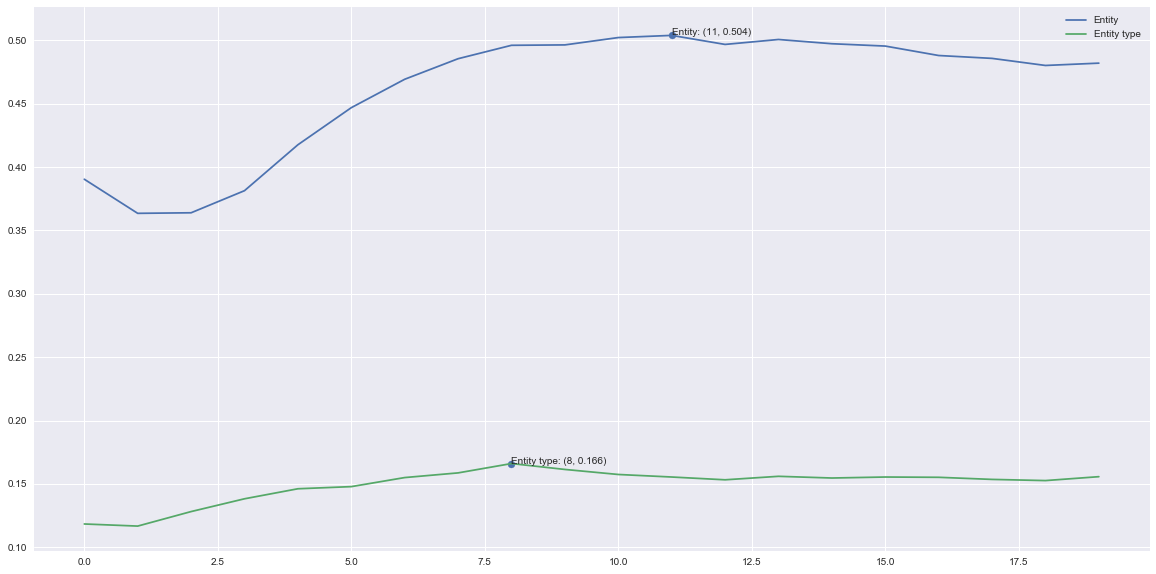

In [34]:
f_entity = [tup[0][-1] for tup in scores]
f_type = [tup[1][-1] for tup in scores]

x = [np.argmax(f_entity), np.argmax(f_type)]
y = [np.max(f_entity), np.max(f_type)]


plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_epochs), f_entity, label='Entity')
plt.plot(np.arange(n_epochs), f_type, label='Entity type')

plt.scatter(x, y)
plt.annotate(f'Entity: ({x[0]}, {np.round(y[0], 3)})', (x[0], y[0]))
plt.annotate(f'Entity type: ({x[1]}, {np.round(y[1], 3)})', (x[1], y[1]))

plt.legend();

## Prediction

In [35]:
y_pred = predict(forward(*model, x=X_val[0]))
y_true = val_labels[0]
for _pred, _true in zip(y_pred, y_true):
    print(_pred, _true, sep='\t')

I-PP	B-NP
B-PRT	I-NP
B-INTJ	I-NP
I-VP	O
B-VP	B-NP
B-PP	B-VP
B-VP	I-VP
B-NP	B-ADVP
B-NP	O
B-NP	B-VP
B-NP	B-PP
B-NP	B-NP
B-NP	B-PP
B-NP	B-NP
B-NP	O


Check for class imbalance.

In [36]:
all_pred, all_true = [], []
for i in trange(len(X_val)):
    y_pred = np.argmax(softmax(forward(*model, x=X_val[i])), axis=1).flatten()
    y_true = np.argmax(y_val[i], axis=1).flatten()
    all_pred.extend(y_pred)
    all_true.extend(y_true)
all_pred = np.asarray(all_pred)
all_true = np.asarray(all_true)

Confusion matrix, without normalization


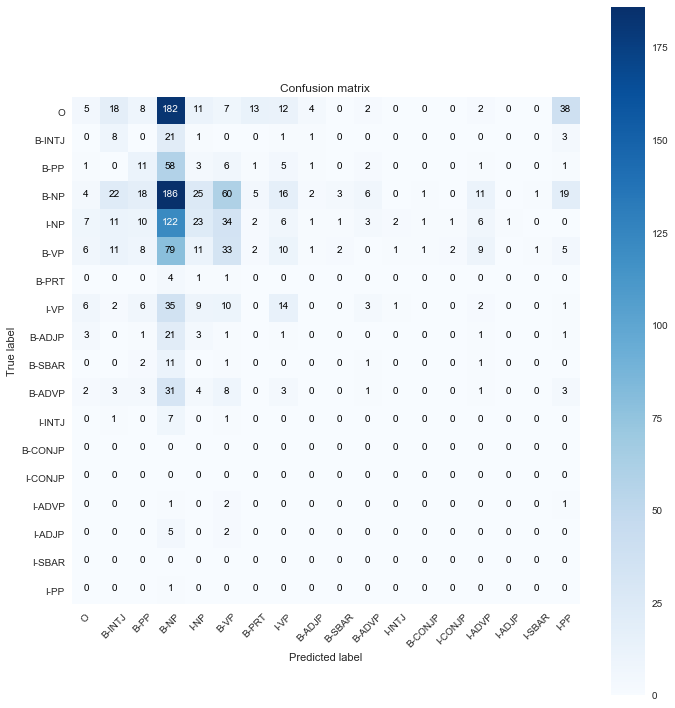

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm = confusion_matrix(all_true, all_pred)
classes = list(state_mapping)

plt.figure(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(cm, classes=classes)

## Save model